## Metagenomic Data Analytics for Predicting CO₂ Emissions: A Data-Driven Approach



This project uses soil data like pH and microbes to teach a computer how to predict the amount of CO₂ gas the soil releases. By predicting this gas, we can understand the soil's health and activity. The goal is to help find the best farming methods that keep soil healthy and are good for the environment.


In [5]:
# ==============================================================================
# 1. SETUP AND LIBRARY IMPORTS
# ==============================================================================
print("--- 1. Importing Libraries ---")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression # <-- Import Linear Regression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

print("Libraries imported successfully!")

--- 1. Importing Libraries ---
Libraries imported successfully!


In [6]:
# ==============================================================================
# 2. DATA LOADING
# ==============================================================================
print("\n--- 2. Loading Data ---")
try:
    df = pd.read_csv("D:\Meta-Genomic-Data-Analytics\Dataset\Soil_microbe_dataset.csv")
    print("✅ Dataset loaded successfully!")
except FileNotFoundError:
    print("❌ Error: 'archive (8).zip/Soil_microbe_dataset.csv' not found.")
    exit()


--- 2. Loading Data ---
✅ Dataset loaded successfully!



--- 3. Generating a comprehensive plot for all features ---

Visualizing 11 numerical features...


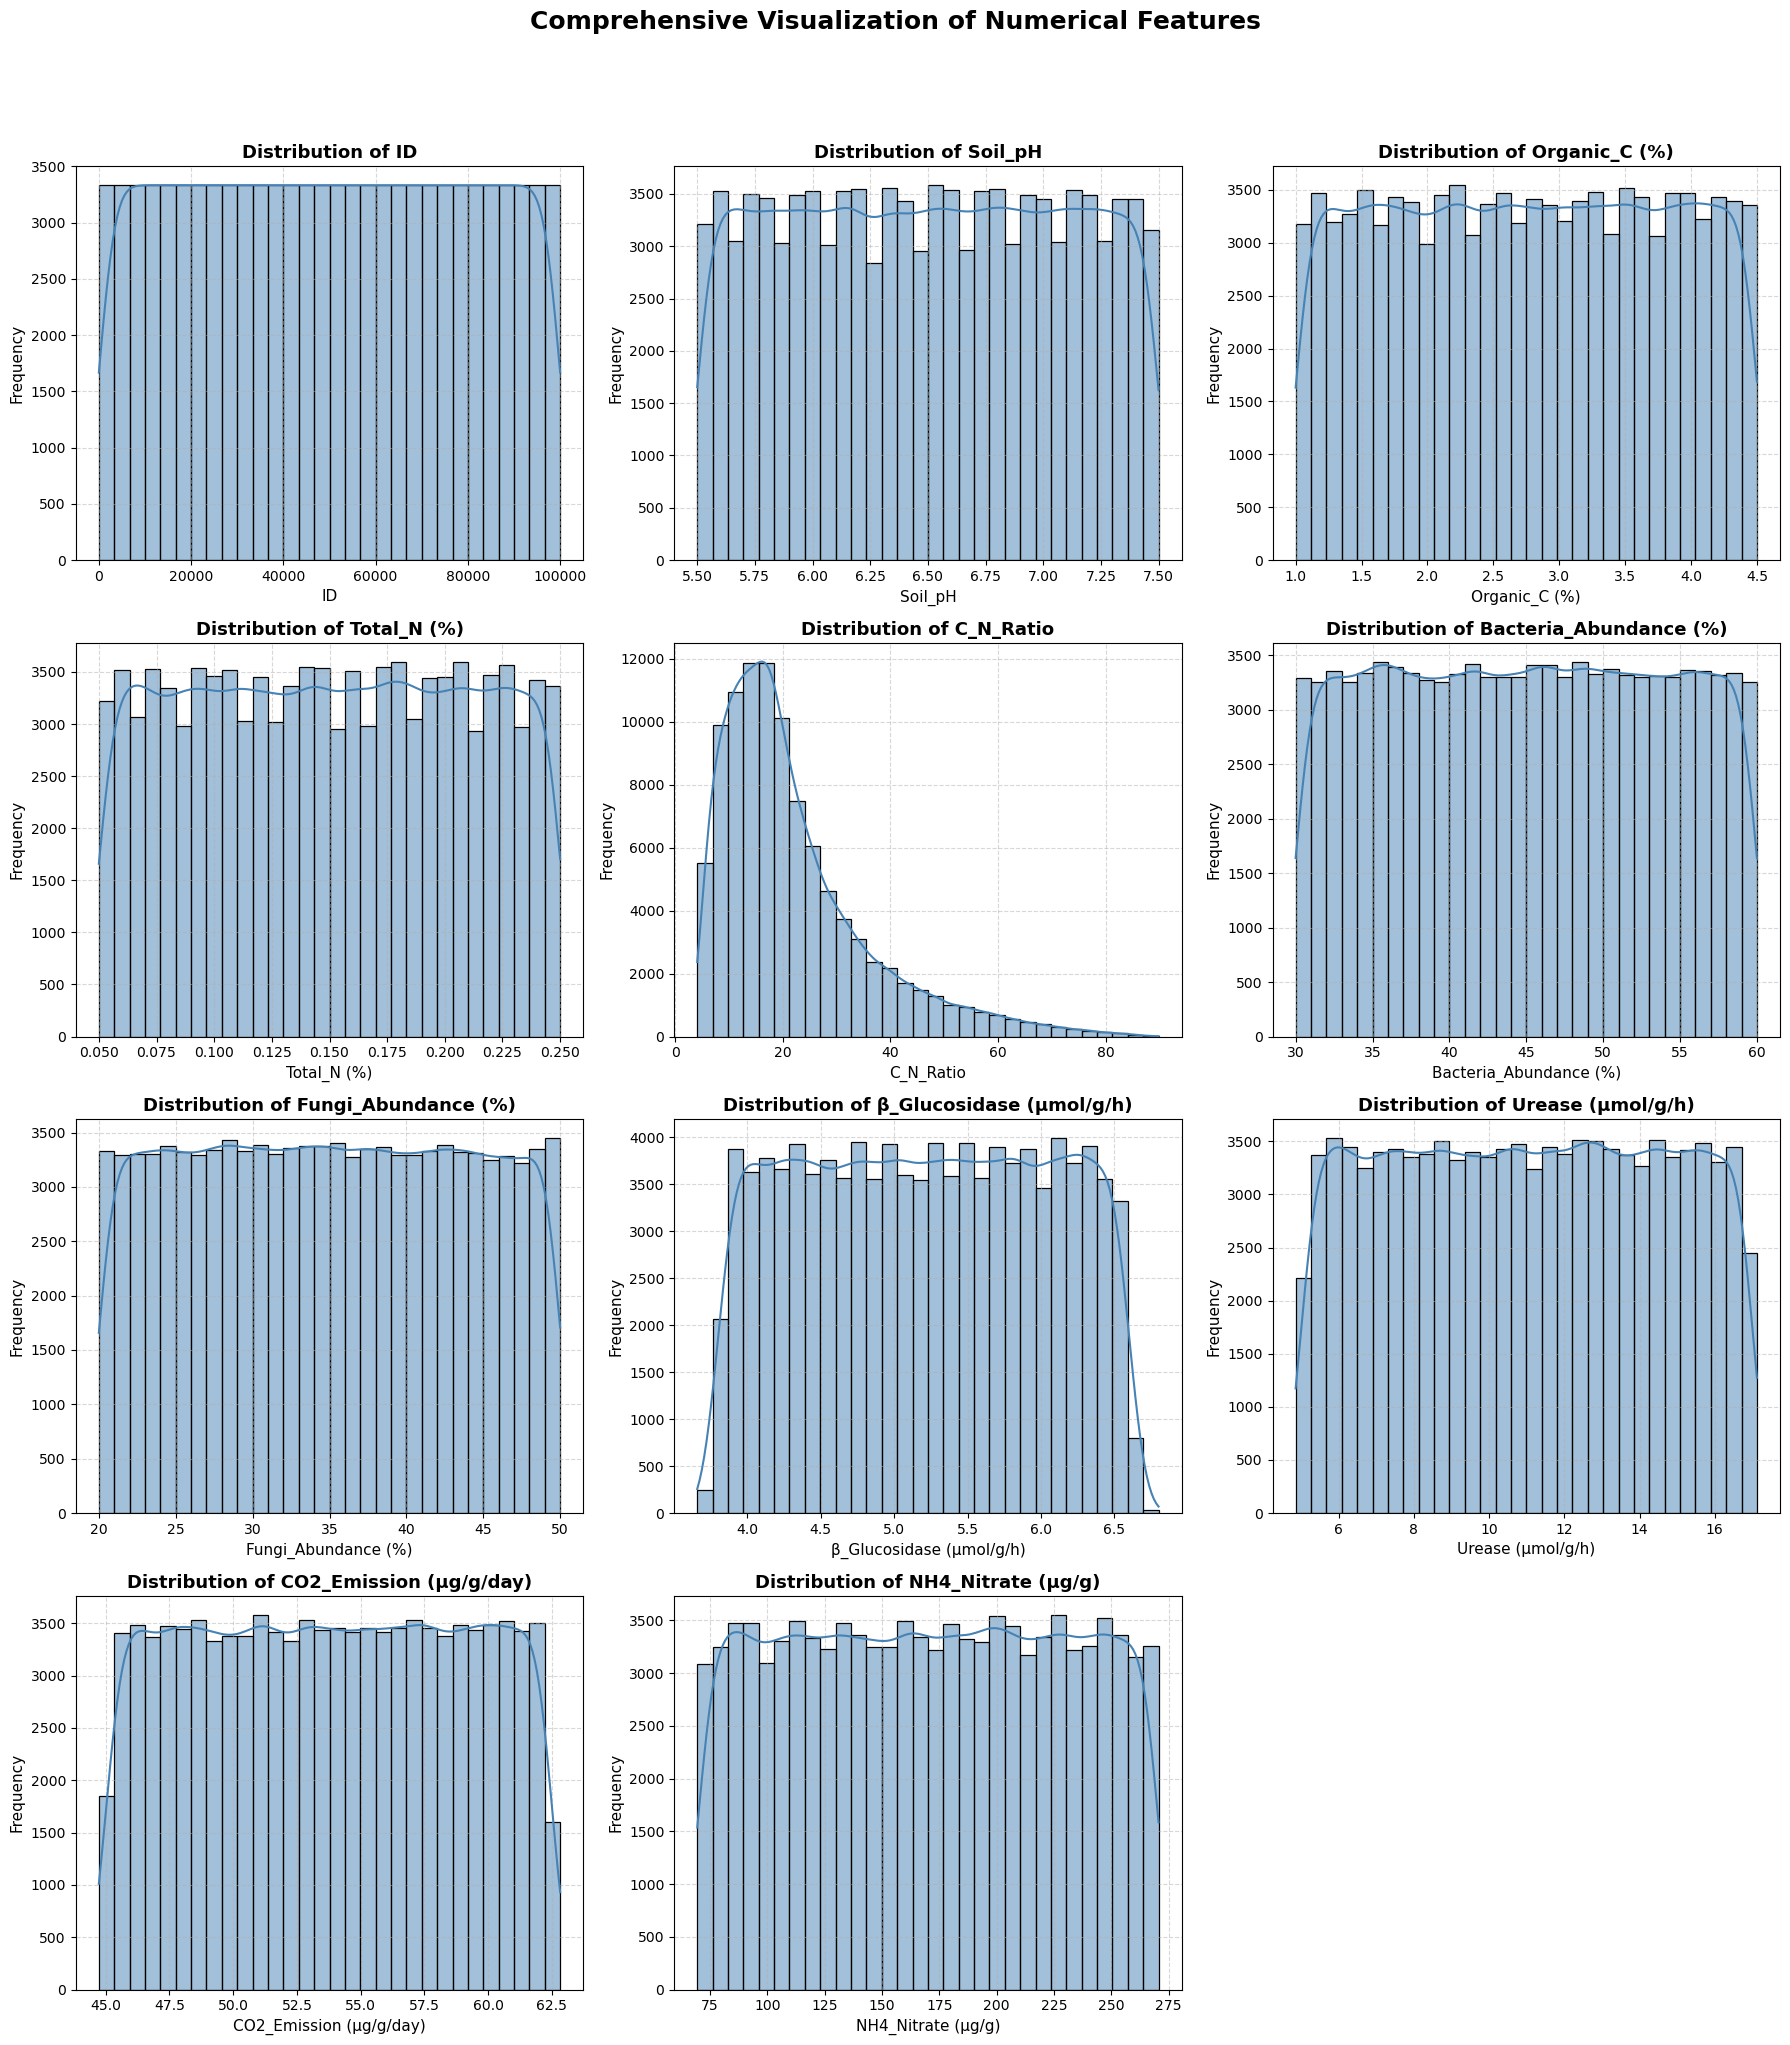

In [ ]:
# ==============================================================================
# 3. COMPREHENSIVE VISUALIZATION OF ALL FEATURES (SEPARATE)
# ==============================================================================
print("\n--- 3. Generating a comprehensive plot for all features ---")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Identify Numerical---
numerical_features = df.select_dtypes(include=np.number).columns.tolist()


# ==============================================================================
# A. Enhanced Visualization of Numerical Features
# ==============================================================================
if numerical_features:
    print(f"\nVisualizing {len(numerical_features)} numerical features...")

    num_features = len(numerical_features)
    cols_per_row = 3  # number of plots per row
    rows = int(np.ceil(num_features / cols_per_row))

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(6 * cols_per_row, 5 * rows))
    axes = axes.flatten()  # Flatten in case of multiple rows

    for i, col in enumerate(numerical_features):
        ax = axes[i]
        sns.histplot(df[col], kde=True, ax=ax, bins=30, color='steelblue', edgecolor='black')
        ax.set_title(f'Distribution of {col}', fontsize=13, fontweight='bold')
        ax.set_xlabel(col, fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.grid(True, linestyle='--', alpha=0.5)

    # Hide empty subplots (if total plots < grid slots)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("Comprehensive Visualization of Numerical Features", fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


--- 3. Performing Exploratory Data Analysis (EDA) ---

Statistical Summary:
                  ID        Soil_pH  Organic_C (%)    Total_N (%)  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean    50000.500000       6.498977       2.754684       0.150123   
std     28867.657797       0.576693       1.010432       0.057764   
min         1.000000       5.500000       1.000000       0.050000   
25%     25000.750000       6.000000       1.880000       0.100000   
50%     50000.500000       6.500000       2.760000       0.150000   
75%     75000.250000       7.000000       3.630000       0.200000   
max    100000.000000       7.500000       4.500000       0.250000   

           C_N_Ratio  Bacteria_Abundance (%)  Fungi_Abundance (%)  \
count  100000.000000           100000.000000        100000.000000   
mean       22.152346               45.003374            34.989532   
std        14.047228                8.640542             8.649368   
min         4.100000     

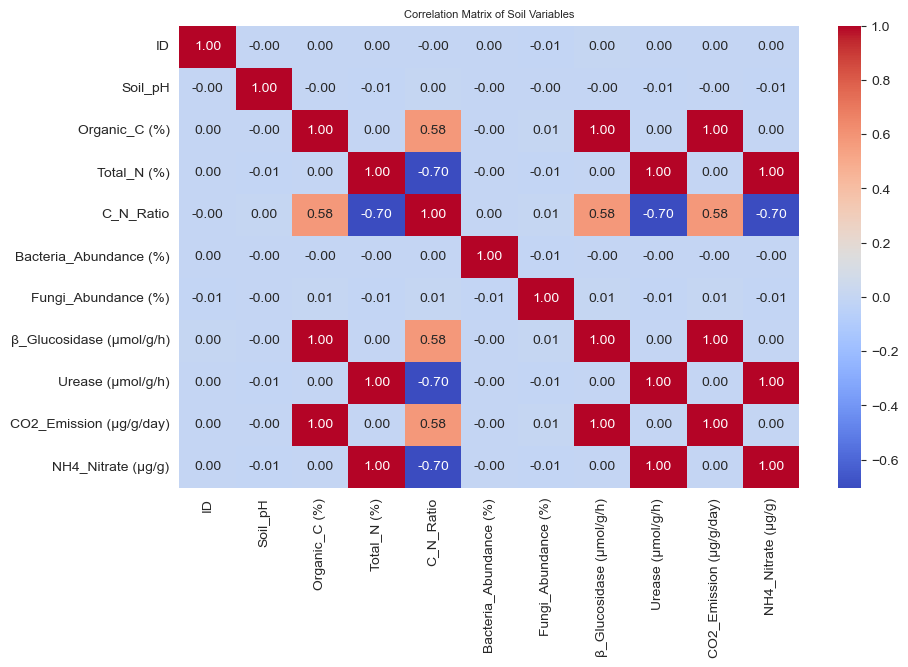

In [12]:
# ==============================================================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ==============================================================================
print("\n--- 3. Performing Exploratory Data Analysis (EDA) ---")
print("\nStatistical Summary:")
print(df.describe())

# --- Visualizations ---
sns.set_style("whitegrid")

# Correlation Matrix Heatmap
print("\nGenerating a correlation matrix heatmap...")
plt.figure(figsize=(10,6))
numeric_df = df.select_dtypes(include=np.number)
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Soil Variables", size=8)
plt.show()

In [13]:
# ==============================================================================
# 4. FEATURE ENGINEERING
# ==============================================================================
print("\n--- 4. Performing Feature Engineering ---")
df['Microbe_Ratio'] = df['Bacteria_Abundance (%)'] / df['Fungi_Abundance (%)']
df['Enzyme_Activity_Index'] = df['β_Glucosidase (µmol/g/h)'] + df['Urease (µmol/g/h)']
print(" Created new features: 'Microbe_Ratio' and 'Enzyme_Activity_Index'.")


--- 4. Performing Feature Engineering ---
 Created new features: 'Microbe_Ratio' and 'Enzyme_Activity_Index'.


In [14]:
# ==============================================================================
# 5. DATA PREPROCESSING & MODEL SETUP
# ==============================================================================
print("\n--- 5. Preparing Data and Setting up Model Pipelines ---")
features = [
    'Soil_pH', 'Organic_C (%)', 'Total_N (%)', 'C_N_Ratio',
    'Land_Use_Type', 'Soil_Depth_cm', 'Bacteria_Abundance (%)',
    'Fungi_Abundance (%)', 'β_Glucosidase (µmol/g/h)', 'Urease (µmol/g/h)',
    'Microbe_Ratio', 'Enzyme_Activity_Index'
]
target = 'CO2_Emission (µg/g/day)'

X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Data split into {len(X_train)} training and {len(X_test)} testing samples.")

# Define preprocessing steps
categorical_features = ['Land_Use_Type', 'Soil_Depth_cm']
numerical_features = X.columns.drop(categorical_features).tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# --- Create Pipelines for BOTH models ---
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))])

pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])

print(" Model pipelines for Random Forest and Linear Regression created.")


--- 5. Preparing Data and Setting up Model Pipelines ---
Data split into 80000 training and 20000 testing samples.
 Model pipelines for Random Forest and Linear Regression created.


In [19]:
# ==============================================================================
# 6. MODEL TRAINING & COMPARATIVE EVALUATION
# ==============================================================================
# --- Train and Evaluate Random Forest ---
print("\n--- Training and Evaluating Random Forest Model ---")
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
print(" Random Forest Training Complete!")

# --- Train and Evaluate Linear Regression ---
print("\n--- Training and Evaluating Linear Regression Model ---")
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
print("Linear Regression Training Complete!")

# --- Print Comparative Results ---
print("\n--- Model Performance Comparison ---")
results = pd.DataFrame({
    'Metric': ['R-squared (R²)', 'Mean Absolute Error (MAE)', 'Mean Absolute Percentage Error (MAPE)'],
    'Random Forest': [f"{r2_rf:.4f}", f"{mae_rf:.2f}", f"{mape_rf:.2%}"],
    'Linear Regression': [f"{r2_lr:.4f}", f"{mae_lr:.2f}", f"{mape_lr:.2%}"]
})
print(results)


--- Training and Evaluating Random Forest Model ---
 Random Forest Training Complete!

--- Training and Evaluating Linear Regression Model ---
Linear Regression Training Complete!

--- Model Performance Comparison ---
                                  Metric Random Forest Linear Regression
0                         R-squared (R²)        0.9996            0.9996
1              Mean Absolute Error (MAE)          0.08              0.08
2  Mean Absolute Percentage Error (MAPE)         0.16%             0.15%
